0. Open
1. Review
2. Topic

    2.1 태깅 작업
    
    2.2 seq2seq
    
3. Q & A
4. Next
5. Close

## 품사 태깅

### 데이터 이해 및 전처리

In [25]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import nltk
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [2]:
tagged_sentences = nltk.corpus.treebank.tagged_sents()
print('품사 태깅된 문장 개수 : {}'.format(len(tagged_sentences)))

품사 태깅된 문장 개수 : 3914


In [3]:
print(tagged_sentences[0])

[('Pierre', 'NNP'), ('Vinken', 'NNP'), (',', ','), ('61', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('will', 'MD'), ('join', 'VB'), ('the', 'DT'), ('board', 'NN'), ('as', 'IN'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('Nov.', 'NNP'), ('29', 'CD'), ('.', '.')]


In [4]:
sentences, pos_tags = [], []

for tagged_sentence in tagged_sentences:
    sentence, tag_info = zip(*tagged_sentence)
    sentences.append(list(sentence))
    pos_tags.append(list(tag_info))

In [5]:
print(sentences[0])
print(pos_tags[0])

['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.']
['NNP', 'NNP', ',', 'CD', 'NNS', 'JJ', ',', 'MD', 'VB', 'DT', 'NN', 'IN', 'DT', 'JJ', 'NN', 'NNP', 'CD', '.']


샘플의 최대 길이 : 271
샘플의 평균 길이 : 25.722023505365357


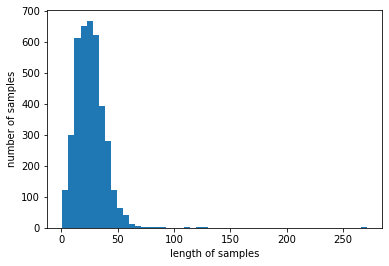

In [6]:
print('샘플의 최대 길이 : {}'.format(max(len(l) for l in sentences)))
print('샘플의 평균 길이 : {}'.format(sum(map(len, sentences))/len(sentences)))
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [7]:
def tokenize(samples):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(samples)
    return tokenizer

In [8]:
src_tokenizer = tokenize(sentences)
ter_tokenizer = tokenize(pos_tags)

In [9]:
vocab_size = len(src_tokenizer.word_index) + 1
tag_size = len(ter_tokenizer.word_index) + 1
print('단어 집합 크기 : {}'.format(vocab_size))
print('태깅 정보 집합 크기 : {}'.format(tag_size))

단어 집합 크기 : 11388
태깅 정보 집합 크기 : 47


In [10]:
X_train = src_tokenizer.texts_to_sequences(sentences)
y_train = ter_tokenizer.texts_to_sequences(pos_tags)

In [11]:
print(X_train[:2])
print(y_train[:2])

[[5601, 3746, 1, 2024, 86, 331, 1, 46, 2405, 2, 131, 27, 6, 2025, 332, 459, 2026, 3], [31, 3746, 20, 177, 4, 5602, 2915, 1, 2, 2916, 637, 147, 3]]
[[3, 3, 8, 10, 6, 7, 8, 21, 13, 4, 1, 2, 4, 7, 1, 3, 10, 9], [3, 3, 17, 1, 2, 3, 3, 8, 4, 3, 19, 1, 9]]


In [12]:
max_len = 150
X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
y_train = pad_sequences(y_train, padding='post', maxlen=max_len)

#### 훈련/테스트 데이터 분할

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=.2, random_state=777)

In [14]:
y_train = to_categorical(y_train, num_classes = tag_size)
y_test = to_categorical(y_test, num_classes = tag_size)

In [15]:
print('훈련 샘플 문장 크기 : {}'.format(X_train.shape))
print('훈련 레이블 문장 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장 크기 : {}'.format(X_test.shape))
print('테스트 레이블 문장 크기 : {}'.format(y_test.shape))

훈련 샘플 문장 크기 : (3131, 150)
훈련 레이블 문장 크기 : (3131, 150, 47)
테스트 샘플 문장 크기 : (783, 150)
테스트 레이블 문장 크기 : (783, 150, 47)


## 양방향 LSTM 이용 POS Tagger 모델

In [16]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding
from tensorflow.keras.optimizers import Adam

In [18]:
model = Sequential()

model.add(Embedding(vocab_size, 128, input_length=max_len, mask_zero=True))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation=('softmax'))))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=128, epochs=6, validation_data=(X_test, y_test))

Train on 3131 samples, validate on 783 samples
Epoch 1/6
 128/3131 [>.............................] - ETA: 5:11 - loss: 0.6809 - accuracy: 0.0106

In [ ]:
print('테스트 정확도 : %.4f' %(model.evaluate(X_test, y_test[1])))

In [ ]:
index_to_word = src_tokenizer.index_word
index_to_tag = ter_tokenizer.index_word

i = 10
y_predicted = model.predict(np.array(X_test[i]))
y_predicted = np.argmax(y_predicted, axis=-1)
true = np.argmax(y_test[i], -1)

print('{:15}|{:15}|{}'.format('단어', '실제값', '예측값'))
print(35*'-')
for w, t, pred in zip(X_test[i], true, y_predicted[0]):
    if w != 0:
        print('{:17}:{:7} {}'.format(index_to_word[w], index_to_tag[t].upper(), index_to_tag[pred].upper()))

## 양방향 LSTM과 CRF(Bidirectional LSTM + CRF) 모델

### CRF(Conditional Random Field)

- CRF는 양방향 LSTM을 위한 모델은 아니고 독자적으로 존재하는 모델이다.
- CRF를 양방향 LSTM 모델 위에 하나의 층으로 추가하여, 양방향 LSTM + CRF 모델을 구축하여 기존 양방향 LSTM을 이용한 태깅 작업에 대한 개선

- 양방향 LSTM 위에 CRF 층을 추가하여 얻을 수 있는 이점은 레이블 사이의 의존성을 고려할 수 있다는 것


1. 문장의 첫번째 단어에서는 I가 나오지 않는다.
2, O-I 패턴은 나오지 않는다.
3. B-I-I에서 개체명은 일관성을 유지한다. 예로 B-per 다음에 O-org는 나오지 않는다.

- 양방향 LSTM은 입력 단어에 대한 양방향 문맥을 반영하며, CRF는 출력 레이블에 대한 양방향 문맥을 반영한다.

CRF layer는 tensorflow 1.3, keras 2.2.4에서만 동작

## 시퀀스 레이블링 평가

- 시퀀스 레이블링 모델을 평가할 때 주의할 점은 큰 의미를 갖지 않는 레이블 정보가 존재하고 이로 인해 정확도가 높은 평가에 방해가 된다.

In [1]:
true = ['B-PER', 'I-PER', 'O', 'O', 'B-MISC', 'O', 'O', 'O', 'O', 'O',
        'O', 'O', 'O', 'O', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O',
        'O', 'O', 'O', 'B-MISC', 'I-MISC', 'I-MISC', 'O', 'O', 'O', 'O',
        'O', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O']
predicted = ['O'] * len(true)
print(predicted)

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [3]:
hit = 0

for t, p in zip(true, predicted):
    if t == p:
        hit += 1
accuracy = hit / len(true) * 100
print('정확도 : %.1f' %(accuracy))

정확도 : 74.4


#### 개체명 인식 모델의 성능 측정을 위한 정밀도와 재현율 개념

- 정밀도 = TP / TP + FP : 특정 객체라고 예측한 경우 중 실제 특정 개체로 판명되어 예측이 일치하는 비율

- 재현율 = TP / TF + FN : 전체 특징 개체 중에서 실제 특정 개체라고 정답을 맞춘 비율

#### 정밀도의 재현율로부터 조화 평균(harmonic mean)을 구한 것을 f1-score라 함

- f1 score = 2 X 정밀도 X 재현률 / 정밀도 + 재현율

In [4]:
!pip install seqeval

  Created wheel for seqeval: filename=seqeval-0.0.12-py3-none-any.whl size=7429 sha256=09d13f93019a69586546658161fabd464b6687f683f50029117933aee5646b49
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\dc\cc\62\a3b81f92d35a80e39eb9b2a9d8b31abac54c02b21b2d466edc
Successfully built seqeval


In [5]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

In [6]:
print(classification_report(true, predicted))

           precision    recall  f1-score   support

      PER       0.00      0.00      0.00         3
     MISC       0.00      0.00      0.00         2

micro avg       0.00      0.00      0.00         5
macro avg       0.00      0.00      0.00         5



In [7]:
true = ['B-PER', 'I-PER', 'O', 'O', 'B-MISC', 'O', 'O', 'O', 'O', 'O',
        'O', 'O', 'O', 'O', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O',
        'O', 'O', 'O', 'B-MISC', 'I-MISC', 'I-MISC', 'O', 'O', 'O', 'O',
        'O', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O']
predicted = ['B-PER', 'I-PER', 'O', 'O', 'B-MISC', 'O', 'O', 'O', 'O', 'O',
             'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
             'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
             'O', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O']
print(predicted)

['B-PER', 'I-PER', 'O', 'O', 'B-MISC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O']


In [8]:
print(classification_report(true, predicted))

           precision    recall  f1-score   support

      PER       1.00      0.67      0.80         3
     MISC       1.00      0.50      0.67         2

micro avg       1.00      0.60      0.75         5
macro avg       1.00      0.60      0.75         5



## Sequence-to-Sequence(seq2seq)

- seq2seq(Sequence-to-Sequence) : 입력된 시퀀스로부터 다른 도메인의 시퀀스를 출력하는 다양한 분야에서 사용되는 모델

- seq2seq 사용 분야
    1. 챗봇(Chatbot) : 입력 시퀀스는 질문, 출력 시퀀스는 답변으로 구성
    2. 기계 번역(Machine Translator) : 입력 시퀀스는 입력 문장, 출력 시퀀스는 번역 문장으로 구성
    3. 내용 요약(Text Summarization) : 입력 시퀀스는 원본 문서, 출력 시퀀스는 요약 내용으로 구성
    4. STT(Speech to Text) : 입력 시퀀스는 음성 데이터, 출력 시퀀스는 음성에 대한 자연어로 구성
    
- seq2seq는 RNN을 기반으로 한 모델

- Counter Vector : 인코더의 처리 결과(은닉 상태)를 디코더의 입력(은닉 상태)으로 전달되는 vector


In [9]:
import pandas as pd

In [12]:
lines = pd.read_csv('fra-eng/fra.txt', names=['src', 'tar', 'comment'], sep='\t')
len(lines)

175623

In [13]:
lines = lines[0:60000]
lines.sample(10)

,src,tar,comment
46718,Have you been drinking?,As-tu bu ?,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
541,Feel this.,Sens ça !,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
2054,He can swim.,Il sait nager.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
22097,You can't give up.,Vous ne pouvez pas arrêter.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
34541,How do you want them?,Comment les veux-tu ?,CC-BY 2.0 (France) Attribution: tatoeba.org #3...
45445,You don't have to lie.,Vous n'êtes pas obligées de mentir.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
284,He tries.,Il essaye.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
36144,"I'm really busy, Tom.","Je suis très occupé, Tom.",CC-BY 2.0 (France) Attribution: tatoeba.org #2...
37194,"Speak slowly, please.","Parlez lentement, je vous prie.",CC-BY 2.0 (France) Attribution: tatoeba.org #5...
55840,It's awfully cold today.,"Aujourd’hui, il fait horriblement froid.",CC-BY 2.0 (France) Attribution: tatoeba.org #1...


In [15]:
lines.tar = lines.tar.apply(lambda x : '\t' + x + '\n')
lines.sample(10)

,src,tar,comment
3129,You're nuts!,\tVous êtes givrée !\n,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
57785,Try to enjoy yourselves.,\tEssayez d'en profiter.\n,CC-BY 2.0 (France) Attribution: tatoeba.org #7...
59424,Children filled the room.,\tLes enfants ont rempli la pièce.\n,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
56263,Please close the window.,\tVeuillez fermer la fenêtre.\n,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
19230,I need a keyboard.,\tIl me faut un clavier.\n,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
38393,We were all so happy.,\tNous étions toutes si heureuses.\n,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
6954,You are early.,\tVous êtes matinale.\n,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
9846,You're winning.,\tVous l'emportez.\n,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
58316,Where are your car keys?,\tOù sont tes clés de voiture ?\n,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
19385,I still have mine.,\tJ'ai toujours la mienne.\n,CC-BY 2.0 (France) Attribution: tatoeba.org #2...


In [16]:
src_vocab = set()

for line in lines.src:
    for char in line:
        src_vocab.add(char)
        
tar_vocab = set()

for line in lines.tar:
    for char in line:
        tar_vocab.add(char)

In [17]:
src_vocab_size = len(src_vocab) + 1
tar_vocab_size = len(tar_vocab) + 1
print(src_vocab_size)
print(tar_vocab_size)

79
106


In [18]:
# sort for indexing
src_vocab = sorted(list(src_vocab))
tar_vocab = sorted(list(tar_vocab))
print(src_vocab[45:75])
print(tar_vocab[45:75])

['W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
['T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w']


In [19]:
src_to_index = dict([(word, i+1) for i, word in enumerate(src_vocab)])
tar_to_index = dict([(word, i+1) for i, word in enumerate(tar_vocab)])
print(src_to_index)
print(tar_to_index)

{' ': 1, '!': 2, '"': 3, '$': 4, '%': 5, '&': 6, "'": 7, ',': 8, '-': 9, '.': 10, '/': 11, '0': 12, '1': 13, '2': 14, '3': 15, '4': 16, '5': 17, '6': 18, '7': 19, '8': 20, '9': 21, ':': 22, '?': 23, 'A': 24, 'B': 25, 'C': 26, 'D': 27, 'E': 28, 'F': 29, 'G': 30, 'H': 31, 'I': 32, 'J': 33, 'K': 34, 'L': 35, 'M': 36, 'N': 37, 'O': 38, 'P': 39, 'Q': 40, 'R': 41, 'S': 42, 'T': 43, 'U': 44, 'V': 45, 'W': 46, 'X': 47, 'Y': 48, 'Z': 49, 'a': 50, 'b': 51, 'c': 52, 'd': 53, 'e': 54, 'f': 55, 'g': 56, 'h': 57, 'i': 58, 'j': 59, 'k': 60, 'l': 61, 'm': 62, 'n': 63, 'o': 64, 'p': 65, 'q': 66, 'r': 67, 's': 68, 't': 69, 'u': 70, 'v': 71, 'w': 72, 'x': 73, 'y': 74, 'z': 75, 'é': 76, '’': 77, '€': 78}
{'\t': 1, '\n': 2, ' ': 3, '!': 4, '"': 5, '$': 6, '%': 7, '&': 8, "'": 9, '(': 10, ')': 11, ',': 12, '-': 13, '.': 14, '0': 15, '1': 16, '2': 17, '3': 18, '4': 19, '5': 20, '6': 21, '7': 22, '8': 23, '9': 24, ':': 25, '?': 26, 'A': 27, 'B': 28, 'C': 29, 'D': 30, 'E': 31, 'F': 32, 'G': 33, 'H': 34, 'I': 3

In [20]:
encoder_input = []
for line in lines.src:
    temp_X = []
    for w in line:
        temp_X.append(src_to_index[w])
    encoder_input.append(temp_X)
print(encoder_input[:5])

[[30, 64, 10], [31, 58, 10], [31, 58, 10], [41, 70, 63, 2], [41, 70, 63, 2]]


In [22]:
decoder_input = []
for line in lines.tar:
    temp_X = []
    for w in line:
        temp_X.append(tar_to_index[w])
    decoder_input.append(temp_X)
print(decoder_input[:5])

[[1, 48, 53, 3, 4, 2], [1, 45, 53, 64, 73, 72, 3, 4, 2], [1, 45, 53, 64, 73, 72, 14, 2], [1, 29, 67, 73, 70, 71, 105, 4, 2], [1, 29, 67, 73, 70, 57, 78, 105, 4, 2]]


In [21]:
decoder_target = []
for line in lines.tar:
    t = 0
    temp_X = []
    for w in line:
        if t > 0:
            temp_X.append(tar_to_index[w])
        t += 1
    decoder_target.append(temp_X)
print(decoder_target[:5])

[[48, 53, 3, 4, 2], [45, 53, 64, 73, 72, 3, 4, 2], [45, 53, 64, 73, 72, 14, 2], [29, 67, 73, 70, 71, 105, 4, 2], [29, 67, 73, 70, 57, 78, 105, 4, 2]]


### 훈련을 위한 padding과 one-hot-encoding

In [23]:
max_src_len = max([len(line) for line in lines.src])
max_tar_len = max([len(line) for line in lines.tar])
print(max_src_len)
print(max_tar_len)

25
74


In [26]:
encoder_input = pad_sequences(encoder_input, maxlen=max_src_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen=max_tar_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen=max_tar_len, padding='post')

In [27]:
encoder_input = to_categorical(encoder_input)
decoder_input = to_categorical(decoder_input)
decoder_target = to_categorical(decoder_target)

### seq2seq 기계 번역 모델 구축 / 훈련

In [30]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

In [33]:
encoder_inputs = Input(shape=(None, src_vocab_size))
encoder_lstm = LSTM(units=256, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
encoder_states = [state_h, state_c]

In [34]:
decoder_inputs = Input(shape=(None, tar_vocab_size))
decoder_lstm = LSTM(units=256, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_softmax_layer = Dense(tar_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [35]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.fit(x=[encoder_input, decoder_input], y = decoder_target, batch_size=64, epochs=50, validation_split=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 375s 8ms/sample - loss: 0.7828 - val_loss: 0.7048
Epoch 2/50
48000/48000 [==============================] - 361s 8ms/sample - loss: 0.4889 - val_loss: 0.5642
Epoch 3/50
48000/48000 [==============================] - 362s 8ms/sample - loss: 0.4057 - val_loss: 0.4959
Epoch 4/50
48000/48000 [==============================] - 370s 8ms/sample - loss: 0.3596 - val_loss: 0.4590
Epoch 5/50
48000/48000 [==============================] - 354s 7ms/sample - loss: 0.3294 - val_loss: 0.4324
Epoch 6/50
48000/48000 [==============================] - 357s 7ms/sample - loss: 0.3076 - val_loss: 0.4139
Epoch 7/50
48000/48000 [==============================] - 358s 7ms/sample - loss: 0.2908 - val_loss: 0.4031
Epoch 8/50
48000/48000 [==============================] - 350s 7ms/sample - loss: 0.2772 - val_loss: 0.3917
Epoch 9/50
48000/48000 [==============================] - 357s 7ms/sample - loss: 0.26

### seq2seq 기계 번역기 동작

- 입력한 문장에 대해 기계 번역을 하도록 모델을 조정
- 전체적인 번역 동작
    1. 번역하고자 하는 입력 문장이 인코더에 들어가서 인닉 상태와 셀 상태를 얻는다.
    2. 상태와 sos에 해당하는 '\t'를 디코더에 보낸다.
    3. 디코더가 eos에 해당하는 '\n\이 나올 때까지 다음 문자를 예측하는 행동을 반복한다.

In [38]:
encoder_model = Model(inputs=encoder_inputs, outputs=encoder_states)

In [39]:
decoder_state_input_h = Input(shape=(256, ))
decoder_state_input_c = Input(shape=(256, ))
decoder_state_inputs = [decoder_state_input_h, decoder_state_input_c]
encoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_softmax_layer(decoder_outputs)
decoder_model = Model(inputs=[decoder_inputs] + decoder_state_inputs, outputs[decoder_outputs] + decoder_states)

SyntaxError: positional argument follows keyword argument (<ipython-input-39-5f5c1f8d1edd>, line 7)

In [ ]:
index_to_src = dict((i, char) for char, i in src_to_index.items())
index_to_tar = dict((i, char) for char, i in tar_to_index.items())

In [ ]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1, 1, tar_vocab_size))
    target_seq[0, 0, tar_to_index['\t']] = 1.

    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = index_to_tar[sampled_token_index]

        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += sampled_char

        # <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_tar_len):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1, 1, tar_vocab_size))
        target_seq[0, 0, sampled_token_index] = 1.

        states_value = [h, c]
        
    return decoded_sentence

In [ ]:
for seq_index in [3, 50, 100, 300, 1001]:
    input_seq = encoder_input[seq_index:seq_index+1]
    decoded_sentence = decoded_sequence(input_seq)
    print(35 * '-')
    print('입력 문장 : {}'.format(lines.src[seq_index]))
    print('정답 문장 : {}'.format(lines.tar[seq_index][1:len(lines.tar[seq_index]) - 1]))
    print('번역기가 번역한 문장 : {}'.format(decoded_sentence[:len(decode_sentence) - 1]))

## 어텐션 매커니즘(Attention Mechanism)

- seq2seq 모델 : 인코더(encoder)에서 입력 시퀀스를 컨텍스트 벡터(context vector)라는 하나의 고정된 크기의 벡터 표현으로 압축하고, 디코더(decoder)는 이 컨텍스트 벡터(context vector)를 통해서 출력 시퀀스를 만들어내는 모델

- seq2seq 모델의 문제점
    1. 하나의 고정된 크기의 벡터에 모든 정보를 압축하려고 하다보니 정보 손실 문제 발생
    2. RNN의 고질적 문제인 기울기 소실(Vanishing Gradient) 문제가 존재
    
- seq2seq 모델의 문제점은 기계 번역 분야에서 입력 문장이 길면 번역 품질이 떨어지는 현상이 나타난다.
- 입력 시퀀스가 길어지면 출력 시퀀스의 정확도가 떨어지는 것을 보정해주기 위한 기법이 어텐션 매커니즘(Attention Mechanism)이다.